# Import Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf 
from keras.utils import np_utils
# for cnn model
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Dense, Conv2D, UpSampling2D, MaxPooling2D, ZeroPadding2D, Reshape
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras import backend as K

Upload Dataset

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/RESEARCH/fer2013.csv")
data.head(10)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training
9,2,255 254 255 254 254 179 122 107 95 124 149 150...,Training


In [ ]:
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [ ]:
X = data['pixels']
y = data['emotion']

In [ ]:
X

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
35882    50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883    178 174 172 173 181 188 191 194 196 199 200 20...
35884    17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885    30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...
35886    19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...
Name: pixels, Length: 35887, dtype: object

In [ ]:
y

0        0
1        0
2        2
3        4
4        6
        ..
35882    6
35883    3
35884    0
35885    3
35886    2
Name: emotion, Length: 35887, dtype: int64

# Expression Distribution

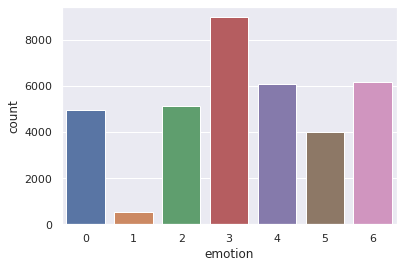

In [ ]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=data)


# Preparing the data

In [ ]:
train_set = data[(data.Usage == 'Training')] 
test_set = data[(data.Usage == 'PrivateTest')] 

In [ ]:
X_train = np.array(list(map(str.split, train_set.pixels)), np.float32) 
X_test = np.array(list(map(str.split, test_set.pixels)), np.float32) 
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1) 
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [ ]:
X_train=X_train/255
X_test=X_test/255

In [ ]:
y_train = train_set.emotion  
y_test = test_set.emotion 

In [ ]:
y_train = np_utils.to_categorical(y_train, 7)
y_test = np_utils.to_categorical(y_test, 7)

In [ ]:
y_test.shape

(3589, 7)

In [ ]:
from keras.callbacks import ReduceLROnPlateau
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

# Building the Model

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(X_train.shape[1:])))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7 , activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam' ,
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                    

# Training the Model

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, callbacks=lr_reduce, validation_data=(X_train,y_train), epochs = 50)

Epoch 1/50
225/225 [==============================] - 472s 2s/step - loss: 0.4224 - accuracy: 0.2037 - val_loss: 0.3896 - val_accuracy: 0.2513 - lr: 0.0010
Epoch 2/50
225/225 [==============================] - 465s 2s/step - loss: 0.3966 - accuracy: 0.2364 - val_loss: 0.3823 - val_accuracy: 0.2533 - lr: 0.0010
Epoch 3/50
225/225 [==============================] - 463s 2s/step - loss: 0.3681 - accuracy: 0.3308 - val_loss: 0.3351 - val_accuracy: 0.4066 - lr: 0.0010
Epoch 4/50
225/225 [==============================] - 462s 2s/step - loss: 0.3254 - accuracy: 0.4266 - val_loss: 0.3002 - val_accuracy: 0.4773 - lr: 0.0010
Epoch 5/50
225/225 [==============================] - 465s 2s/step - loss: 0.2970 - accuracy: 0.4991 - val_loss: 0.2761 - val_accuracy: 0.5395 - lr: 0.0010
Epoch 6/50
225/225 [==============================] - 465s 2s/step - loss: 0.2774 - accuracy: 0.5429 - val_loss: 0.2469 - val_accuracy: 0.5985 - lr: 0.0010
Epoch 7/50
225/225 [==============================] - 463s 2s/st

In [ ]:
# computing the accuracy
print("Accuracy of our model on validation data : " , model.evaluate(X_train,y_train)[1]*100 , "%")

898/898 [==============================] - 93s 103ms/step - loss: 0.0114 - accuracy: 0.9887
Accuracy of our model on validation data :  98.87491464614868 %


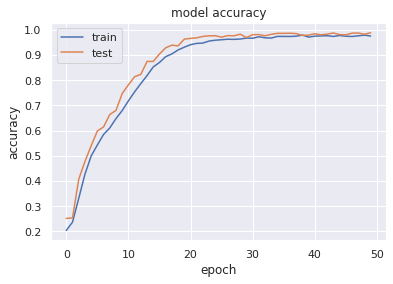

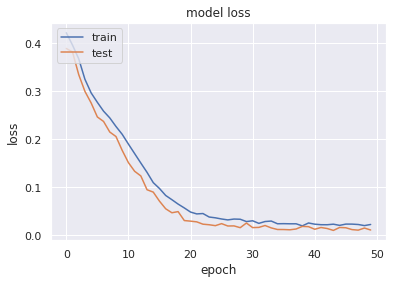

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Predicition 

In [ ]:


y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)



In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,0,1.0
1,0,0.0
2,1,0.0
3,0,0.0
4,0,0.0
5,0,0.0
6,0,0.0
7,1,0.0
8,0,0.0
9,0,0.0


In [ ]:
# model_name = 'Human_Emotion_Model.h5'
# save_dir = os.path.join(os.getcwd(), 'saved_models')
# # Save model and weights
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# model_path = os.path.join(save_dir, model_name)
# model.save(model_path)
# print('Saved trained model at %s ' % model_path)

In [ ]:
#Saving the  model to  use it later on  
fer_json = model.to_json()  
with open("fer.json", "w") as json_file:  
    json_file.write(fer_json)  
model.save_weights("fer.h5") 

In [ ]:
df.tail(20)

,Predicted Labels,Actual Labels
25103,0,0.0
25104,0,0.0
25105,0,0.0
25106,0,0.0
25107,0,0.0
25108,1,0.0
25109,0,0.0
25110,0,0.0
25111,0,0.0
25112,1,1.0
